$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
$$

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
import mnist

sns.set(style="white", color_codes=True)

np.random.seed(42)

In [2]:
train_examples = mnist.train_images().astype("float32")
train_labels = mnist.train_labels()
train_examples = {str(label): train_examples[train_labels==label]
                  for label in set(train_labels)}
del train_labels
D = train_examples['0'].shape[1]

In [3]:
covariances = dict()
for k, v in train_examples.items():
    v = np.copy(v)
    v /= 255.0
    v -= np.mean(v, axis=0)
    v_flat = np.reshape(v, (-1, D * D))
    covariances[k] = v_flat.T @ v_flat / (v.shape[0] - 1)

Example covariance matrices for digits 0, 2 and 5:

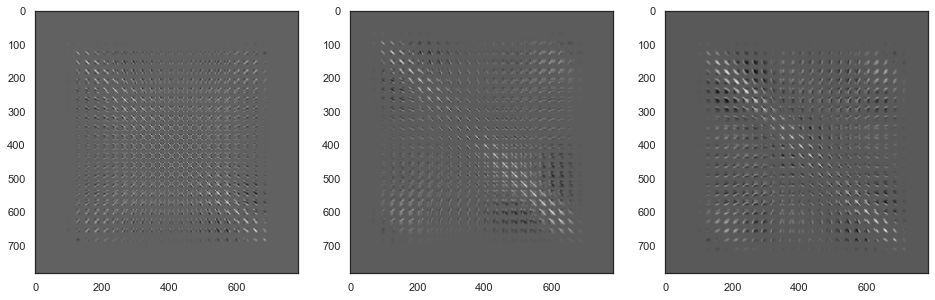

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
for i, digit in enumerate((0, 2, 5)):
    C = covariances[str(digit)]
    axes[i].imshow(C, cmap='gray', vmin=np.min(C), vmax=np.max(C))
plt.show()

We will now play a game to illustrate what the entries of the covariance matrix are. Consider a blank, 28 x 28 canvas.

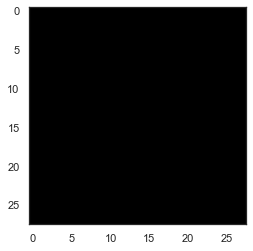

In [5]:
canvas = np.zeros((D, D))
plt.imshow(canvas, cmap='gray')
plt.show()

Now let's take a ground truth, hidden example of a randomly chosen digit 2.

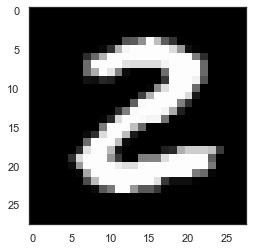

In [6]:
gt = train_examples['2'][2] / 255.0
plt.imshow(gt, cmap='gray')
plt.show()

The goal is to fill the blank canvas to resemble a digit 2. Given the covariance matrix for all examples of digits 2, if you are told about a single pixel value of the ground truth, can you use that information when filling the canvas?

Concretely, suppose you are told the value of pixel at position (18, 8) = 512, highlighted below.

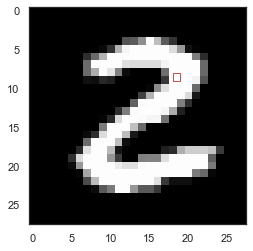

In [7]:
plt.imshow(gt, cmap='gray')
plt.gca().add_patch(Rectangle((18,8),1,1,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

Now consider the 512th row of the covariance matrix. It tells us, on average, how every other pixel behaves given the value of pixel at (18, 8). Our reference pixel is evidently taking on a large value. If we go through each value in the said row, a high value indicates that the candidate pixel is likely to be large as well, and vice-versa.

This motivates the following demonstration. We will randomly sample (without replacement) entries of our ground truth image. For each ground truth pixel, since we know on average what the product of this pixel and all other pixels is, we can make a guess for the value of all other pixels. Using these guesses we populate the canvas by overlaying the corresponding row of the covariance matrix through a running average. The iterations are then shown as an animation.

In [8]:
canvas = np.zeros((D, D))
canvases = []
num_samples = 300
i = 1
for pixel in np.random.choice(D * D, size=num_samples, replace=False):
    gt_row, gt_col = pixel // D, pixel % D
    if gt[gt_row, gt_col] == 0:
        continue
    xixj = covariances['2'][pixel]
    canvas *= (i - 1) / i
    canvas += (xixj.reshape(D, D) / gt[gt_row, gt_col]) / i
    canvases.append((canvas - np.min(canvas)) / np.ptp(canvas))
    i += 1

In [9]:
def animate_image(image_arr):
    fig = plt.figure()
    all_frames = [[plt.imshow(image, cmap='gray', vmin=0, vmax=1)] for image in image_arr]
    ani = animation.ArtistAnimation(fig, all_frames, interval=300, blit=False, repeat=False)
    return ani

In [19]:
%%capture
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
ani = animate_image(canvases)

In [20]:
ani